In [1]:
import matplotlib.container
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import time
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.ensemble import IsolationForest
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier
# import hyperopt
import xgboost as xgb

In [2]:
df = pd.read_csv('data.csv', sep=';')
df.head()

,ID,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,target
0,1,1,0,0,1381,63,0,0,1,0,...,0,0,0,0.0,7000,4000,7526.3157,12000,0.583333,0
1,2,0,0,0,1809,33,1,0,1,0,...,0,0,0,0.0,10000,1000,8393.4426,30000,0.333333,0
2,3,0,0,0,1804,29,0,1,0,0,...,0,0,0,0.0,3000,1000,3425.9259,15000,0.200000,0
3,4,0,0,0,1560,28,1,1,0,0,...,0,0,0,0.0,2000,1000,1946.6666,3000,0.666667,0
4,5,0,0,0,258,33,1,0,0,0,...,0,0,0,0.0,2000,2000,4444.4444,8000,0.250000,0


## ID неинформативный столбец, уберем его

In [3]:
df = df.drop('ID', axis=1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255820 entries, 0 to 255819
Columns: 125 entries, feature_1 to target
dtypes: float64(21), int64(104)
memory usage: 244.0 MB


In [5]:
df.isnull().sum().sort_values(ascending=False)

feature_106    41893
feature_102    37795
feature_103    37795
feature_104    37795
feature_105    37795
               ...  
feature_38         0
feature_37         0
feature_36         0
feature_35         0
target             0
Length: 125, dtype: int64

In [6]:
np.sum(df.isnull().sum().sort_values(ascending=False))

193073

### Борьбу с пропусками осуществим в несколько вариантов: удалим те строки, где пропуски в данных. Однако это черевато тем, что в худшем случае у нас из 255_820 данных 193_073 будут составлять пропуски. Второй вариант, это заполнить пропуски средним значением по столбцу (однако этот метод плохо работает с категориальными признаками). Лучшим способом было бы использовать KNNInputer, который ищет ближайших соседей и вставляет в данную ячейку среднее значение соседей. Но данный метод работает долго

In [7]:
df_drop_null = df.dropna()
df_drop_null.reset_index(inplace=True, drop=True)
df_drop_null.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213927 entries, 0 to 213926
Columns: 125 entries, feature_1 to target
dtypes: float64(21), int64(104)
memory usage: 204.0 MB


In [8]:
df_mean_null = df.fillna(df.mean)
df_mean_null.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255820 entries, 0 to 255819
Columns: 125 entries, feature_1 to target
dtypes: float64(16), int64(104), object(5)
memory usage: 244.0+ MB


### После удаления пустых значений сохранили 83.6% исходного датасета. Используем очищенный датасет

In [9]:
# imputer = KNNImputer(n_neighbors=2)
# df_knn_null =imputer.fit_transform(df.copy())

In [10]:
# df['target'].plot.bar()
# plt.show()

### Удалим высококоррелированные столбцы

In [11]:
def trimm_correlated(df_in, threshold=0.3):
    df_corr = df_in.corr(method='pearson', min_periods=1)
    df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > threshold).any()
    df_correlated = (df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > threshold).any()
    un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
    cors = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == False]
    df_out = df_in[un_corr_idx]
    return df_out, cors.index

In [12]:
df_non_correlated_drop, corr = trimm_correlated(df_drop_null, threshold=0.5)
df_non_correlated_drop

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_9,feature_10,feature_11,...,feature_102,feature_106,feature_107,feature_108,feature_110,feature_111,feature_116,feature_120,feature_121,target
0,1,0,0,1381,63,0,0,0,0,0,...,61.0,0.610000,0,4,0,0,0,7000,4000,0
1,0,0,0,1809,33,1,0,0,0,1,...,0.0,0.000000,1,5,0,0,0,10000,1000,0
2,0,0,0,1804,29,0,1,0,0,1,...,16.0,0.139130,0,3,0,5,0,3000,1000,0
3,0,0,0,1560,28,1,1,0,0,0,...,5.0,0.043103,0,0,0,0,0,2000,1000,0
4,0,0,0,258,33,1,0,0,1,0,...,1.0,0.071429,0,0,0,0,0,2000,2000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213922,0,0,0,63,66,0,0,0,1,0,...,10.0,0.909091,0,0,0,0,0,1150,1150,0
213923,0,0,0,501,29,0,1,0,0,1,...,26.0,0.313253,0,1,0,0,0,3000,1000,0
213924,1,0,0,99,64,0,0,0,0,0,...,21.0,0.777778,0,0,0,0,0,5800,2400,0
213925,0,0,0,43,33,0,1,0,0,0,...,23.0,1.000000,0,0,0,0,0,2000,2000,0


### Запомним имена высокоррелированных столбцов. Нам они понадобятся при чистке verify.csv

In [13]:
corr

Index(['feature_8', 'feature_12', 'feature_16', 'feature_28', 'feature_30',
       'feature_31', 'feature_48', 'feature_49', 'feature_55', 'feature_76',
       'feature_80', 'feature_82', 'feature_83', 'feature_84', 'feature_86',
       'feature_87', 'feature_93', 'feature_94', 'feature_96', 'feature_97',
       'feature_98', 'feature_99', 'feature_100', 'feature_101', 'feature_103',
       'feature_104', 'feature_105', 'feature_109', 'feature_112',
       'feature_113', 'feature_114', 'feature_115', 'feature_117',
       'feature_118', 'feature_119', 'feature_122', 'feature_123',
       'feature_124'],
      dtype='object')

### Посмотрим c какими типами значений (категориальные (0, 1, ..., N) или рациональные) нам приходится сталкиваться

In [14]:
df_non_correlated_drop.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_9,feature_10,feature_11,...,feature_102,feature_106,feature_107,feature_108,feature_110,feature_111,feature_116,feature_120,feature_121,target
count,213927.000000,213927.000000,213927.000000,213927.000000,213927.000000,213927.000000,213927.000000,213927.000000,213927.00000,213927.000000,...,213927.000000,213927.000000,213927.000000,213927.000000,213927.000000,213927.000000,213927.000000,213927.000000,213927.000000,213927.000000
mean,0.346679,0.000019,0.001094,943.315178,41.278422,0.412487,0.348264,0.063863,0.14196,0.248066,...,61.142469,0.352597,0.076026,1.233257,0.067841,0.485053,0.014860,7394.408494,2298.540703,0.164149
std,0.475914,0.004324,0.033055,766.946139,13.666285,0.492283,0.476421,0.244509,0.34901,0.431891,...,196.644212,0.518324,0.265040,2.658280,0.258241,1.289681,0.120994,8447.649726,2144.660777,0.370412
min,0.000000,0.000000,0.000000,1.000000,18.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,-490.000000,-76.600000,0.000000,0.000000,0.000000,0.000000,0.000000,1000.000000,1000.000000,0.000000
25%,0.000000,0.000000,0.000000,285.000000,30.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,4.000000,0.031646,0.000000,0.000000,0.000000,0.000000,0.000000,2000.000000,1000.000000,0.000000
50%,0.000000,0.000000,0.000000,746.000000,38.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,12.000000,0.146341,0.000000,0.000000,0.000000,0.000000,0.000000,4000.000000,2000.000000,0.000000
75%,1.000000,0.000000,0.000000,1465.000000,52.000000,1.000000,1.000000,0.000000,0.00000,0.000000,...,33.000000,0.752187,0.000000,1.000000,0.000000,0.000000,0.000000,10000.000000,2000.000000,0.000000
max,1.000000,1.000000,1.000000,3451.000000,82.000000,1.000000,1.000000,1.000000,1.00000,1.000000,...,3278.000000,9.428571,1.000000,67.000000,6.000000,32.000000,1.000000,99000.000000,44000.000000,1.000000


### Столбцы с минимальным значением 0 проверим на категориальные фичи по признаку: если количество уникальных значений (напр. 0, 1, 2) равно максимальному значению по выборке (в нашем случае 2) + 1, значит фича категориальная и её не будем использовать в нормализации и проверке на выбросы.
### Категориальные фичи нельзя использовать в нормализации, поскольку если 1-Москва, а 2-Спб, то что тогда 1.5??

### Получим имена категориальных и рациональных фич

In [15]:
category_features = []
rational_features = []

for col_name in df_non_correlated_drop.columns:
    if (df_non_correlated_drop.describe()[col_name]['min'] == 0) and (df_non_correlated_drop.describe()[col_name]['max'] + 1 == len(pd.unique(df_non_correlated_drop[col_name]))):
        category_features.append(col_name)
    else:
        rational_features.append(col_name)



In [16]:
len(category_features)

67

In [17]:
len(rational_features)

20

### Рассмотрим распределение по классам target-а

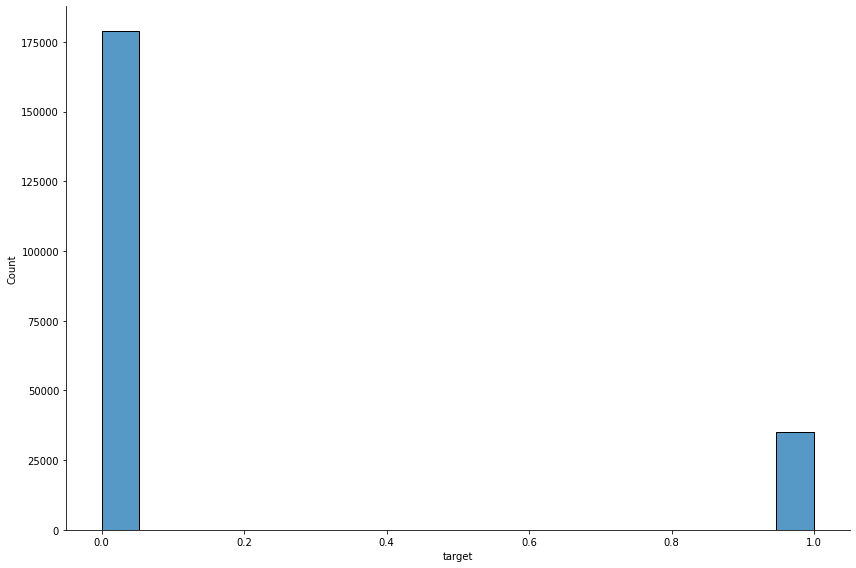

In [18]:
sns.displot(df_non_correlated_drop, x="target", height=8,aspect=1.5)

In [19]:
scale_pos_weight = len(df_non_correlated_drop[df_non_correlated_drop['target'] == 0]) / len(df_non_correlated_drop[df_non_correlated_drop['target'] == 1])
scale_pos_weight

5.09200934047158

### Борьба с выбросами интерквантильным размахом

In [20]:
Q1 = df_non_correlated_drop[rational_features].quantile(0.25)
Q3 = df_non_correlated_drop[rational_features].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

feature_4       1180.000000
feature_5         22.000000
feature_19         3.700000
feature_47      5000.000000
feature_50     23000.000000
feature_53         0.000000
feature_54       400.000000
feature_85         4.000000
feature_88         0.694853
feature_89         0.385570
feature_90         1.000000
feature_91         6.000000
feature_92         0.000000
feature_95         1.000000
feature_102       29.000000
feature_106        0.720541
feature_108        1.000000
feature_111        0.000000
feature_120     8000.000000
feature_121     1000.000000
dtype: float64


In [21]:
df_non_correlated_drop_o = df_non_correlated_drop[~((df_non_correlated_drop[rational_features] < (Q1 - 1.5 * IQR)) |(df_non_correlated_drop[rational_features] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [22]:
df_non_correlated_drop_o

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_9,feature_10,feature_11,...,feature_102,feature_106,feature_107,feature_108,feature_110,feature_111,feature_116,feature_120,feature_121,target
3,0,0,0,1560,28,1,1,0,0,0,...,5.0,0.043103,0,0,0,0,0,2000,1000,0
4,0,0,0,258,33,1,0,0,1,0,...,1.0,0.071429,0,0,0,0,0,2000,2000,0
5,0,0,0,377,48,1,0,0,0,0,...,1.0,0.003534,0,0,0,0,0,2000,2000,0
6,0,0,0,2442,66,1,0,0,1,1,...,21.0,0.064024,0,0,0,0,0,2000,1000,0
8,1,0,0,526,27,0,0,0,0,1,...,74.0,1.000000,0,0,0,0,0,2000,1000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213921,0,0,0,1491,63,1,0,0,1,0,...,46.0,0.389831,0,0,0,0,0,1000,1000,1
213922,0,0,0,63,66,0,0,0,1,0,...,10.0,0.909091,0,0,0,0,0,1150,1150,0
213924,1,0,0,99,64,0,0,0,0,0,...,21.0,0.777778,0,0,0,0,0,5800,2400,0
213925,0,0,0,43,33,0,1,0,0,0,...,23.0,1.000000,0,0,0,0,0,2000,2000,0


### Видно, что классы несбалансированны. Класс target == 0 в 5 раз больше target == 1. Поэтому разбивать на тренировку и тест нужно с условием несбалансированности классов. Либо можно попробовать использовать различные методы семплирования и десемплирования выборок, а также добавлением весов в классы.
## Я буду использовать разбиение по классам и применение весов для дисбаланса классов

# Метод разбиения stratify по классам

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    df_non_correlated_drop.iloc[:, :-1], df_non_correlated_drop.iloc[:, -1], test_size=0.33, random_state=42, stratify=df_non_correlated_drop['target'])
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [24]:
scaler = StandardScaler()
X_train[rational_features] = scaler.fit_transform(X_train[rational_features].values)
X_test[rational_features] = scaler.transform(X_test[rational_features].values)

## Base model for stratify spliting

In [25]:
classes = np.unique(y_train.values.ravel())
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train.values.ravel())
class_weights = dict(zip(classes, weights))

In [26]:
def base_models(X_train=X_train, X_test=X_test, y_test = y_test.values.ravel(), y_train = y_train.values.ravel()):
    regressors = {
        "LogisticRegression ": LogisticRegression(random_state=1, max_iter=10000, class_weight=class_weights),
        'CatBoost': CatBoostClassifier(iterations=10000,
                                       task_type="GPU",
                                       devices='0:1', eval_metric='TotalF1',
                                       class_weights=class_weights, verbose=False,
                                       loss_function='Logloss'),
        'LGMB': LGBMClassifier(class_weight='balanced', n_estimators=50),
        'XGBM': xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
    }

    df_models = pd.DataFrame(columns=['model', 'run_time','rmse', 'f1_score', 'ROC_AUC', 'logisticloss'])

    for key in regressors:

        start_time = time.time()

        regressor = regressors[key]
        model = regressor.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # scores = cross_val_score(model,
        #                          X_train,
        #                          y_train.values.ravel(),
        #                          scoring='f1',
        #                          cv=10)


        row = {'model': key,
               'run_time': format(round((time.time() - start_time)/60,2)),
               'rmse': (np.sqrt(mean_squared_error(y_test, y_pred))),
               'f1_score': f1_score(y_test, y_pred),
               'ROC_AUC': roc_auc_score(y_test, y_pred),
               'logisticloss': log_loss(y_test, y_pred)
               }

        df_models = df_models.append(row, ignore_index=True)
    return df_models
base_models().head()

C:\Users\gto_n\.conda\envs\raifhack_2021\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:26:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,model,run_time,rmse,f1_score,ROC_AUC,logisticloss
0,LogisticRegression,0.19,0.553654,0.424682,0.691772,10.587477
1,CatBoost,1.48,0.532714,0.451964,0.714881,9.801734
2,LGMB,0.01,0.543337,0.446792,0.713417,10.196566
3,XGBM,0.15,0.526253,0.445849,0.705242,9.565418


### Попробуем технику UNDERSAMPLING для борьбы с несбалансированностью классов

In [27]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=1)
X_res, y_res = rus.fit_resample(X_train, y_train.values.ravel())
base_models(X_train=X_res, X_test=X_test, y_test=y_test, y_train=y_res)

C:\Users\gto_n\.conda\envs\raifhack_2021\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:33:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,model,run_time,rmse,f1_score,ROC_AUC,logisticloss
0,LogisticRegression,0.06,0.866197,0.301785,0.546290,25.914955
1,CatBoost,6.36,0.812488,0.326478,0.594953,22.800833
2,LGMB,0.01,0.542058,0.446337,0.712341,10.148618
3,XGBM,0.06,0.772513,0.341451,0.619921,20.612383


### Попробуем технику OVERSAMPLING для борьбы с несбалансированностью классов

In [28]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train.values.ravel())
base_models(X_train=X_ros, X_test=X_test, y_test = y_test, y_train = y_ros)

C:\Users\gto_n\.conda\envs\raifhack_2021\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,model,run_time,rmse,f1_score,ROC_AUC,logisticloss
0,LogisticRegression,0.4,0.864380,0.302523,0.547894,25.806340
1,CatBoost,1.45,0.787072,0.336947,0.612926,21.396664
2,LGMB,0.02,0.541391,0.446501,0.712253,10.123666
3,XGBM,0.24,0.757533,0.345398,0.625517,19.820763


## Лучше всего (и быстрее) себя ведет LGBM. Его и будем тюнить

In [38]:
params = {
    'application': 'binary', # for binary classification
    #     'num_class' : 1, # used for multi-classes
    'boosting': 'gbdt', # traditional gradient boosting decision tree
    'num_iterations': 100,
    'learning_rate': 0.05,
    'num_leaves': 62,
    'device': 'cpu', # you can use GPU to achieve faster learning
    'max_depth': -1, # <0 means no limit
    'max_bin': 510, # Small number of bins may reduce training accuracy but can deal with over-fitting
    'lambda_l1': 5, # L1 regularization
    'lambda_l2': 10, # L2 regularization
    'metric' : 'binary_error',
    'subsample_for_bin': 200, # number of samples for constructing bins
    'subsample': 1, # subsample ratio of the training instance
    'colsample_bytree': 0.8, # subsample ratio of columns when constructing the tree
    'min_split_gain': 0.5, # minimum loss reduction required to make further partition on a leaf node of the tree
    'min_child_weight': 1, # minimum sum of instance weight (hessian) needed in a leaf
    'min_child_samples': 5# minimum number of data needed in a leaf
}

# Initiate classifier to use
mdl = LGBMClassifier(boosting_type= 'gbdt',
                     objective = 'binary',
                     class_weight=class_weights,
                     n_jobs = 6,
                     silent = True,
                     max_depth = params['max_depth'],
                     max_bin = params['max_bin'],
                     subsample_for_bin = params['subsample_for_bin'],
                     subsample = params['subsample'],
                     min_split_gain = params['min_split_gain'],
                     min_child_weight = params['min_child_weight'],
                     min_child_samples = params['min_child_samples'])

# To view the default model parameters:
mdl.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq', 'max_bin'])

In [39]:
gridParams = {
    'learning_rate': [0.005, 0.01],
    'n_estimators': [8,16,24],
    'num_leaves': [6,8,12,16], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
    'objective' : ['binary'],
    'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
    'random_state' : [500],
    'colsample_bytree' : [0.64, 0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
}

grid = GridSearchCV(mdl, gridParams, verbose=1, cv=4, n_jobs=-1)
# Run the grid
grid.fit(X_train, y_train.values.ravel())
# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 4 folds for each of 3456 candidates, totalling 13824 fits
{'boosting_type': 'dart', 'colsample_bytree': 0.66, 'learning_rate': 0.01, 'max_bin': 255, 'n_estimators': 16, 'num_leaves': 6, 'objective': 'binary', 'random_state': 500, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.7}
0.7063162467415778


In [58]:
model = LGBMClassifier(boosting_type='dart',colsample_bytree=0.66, learning_rate=0.01, max_bin=255,n_estimators=16, num_leaves=6, random_state=500, reg_alpha=1, reg_lambda=1,subsample=0.7 ,objective = 'binary', class_weight=class_weights)
model.fit(X_train, y_train.values.ravel())
y_pred = model.predict(X_test)
f1_score(y_test, y_pred)

0.4214563305379423

## Лучшие метрики я получил на LGBMC при стандартных гиперпараметрах, его и буду использовать для получения конечного результата

### Проверим модель на переобученность. Если метрика на test-выборке сильно меньше метрики на train-выборке, значит модель сильно переобучилась

In [26]:
clf = LGBMClassifier(class_weight='balanced', n_estimators=50)
clf.fit(X_train, y_train.values.ravel())

LGBMClassifier(class_weight='balanced', n_estimators=50)

### Метрики на train-выборке

In [59]:
f1_score(y_train, clf.predict(X_train))

0.45821559392987965

### Метрики на test-выборке

In [60]:
f1_score(y_test, clf.predict(X_test))

0.4467921322963395

### Метрики практически индентичны. Это значит, что модель не явлвяется переобученной. Используем её для получения финального результата

In [32]:
y_pred = clf.predict_proba(X_test)
y_pred[:, -1]

array([0.24640163, 0.24870044, 0.59011239, ..., 0.79243171, 0.30125532,
       0.18688952])

In [54]:
group_df = pd.DataFrame({'Вероятность':np.squeeze(y_pred[:, -1]), 'target':np.squeeze(y_test.values)})
group_df
group_df.to_excel('group.xlsx')

In [27]:
verify_df = pd.read_csv('verify.csv', sep=';')
verify_df

,ID,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124
0,255821,0,0,0,2268,34,0,1,0,0,...,1,0,0,0,0.0,6000,1000,4551.0204,12000,0.500000
1,255822,0,0,0,42,49,0,0,1,0,...,0,0,0,0,0.0,6000,3400,4700.0000,6000,1.000000
2,255823,0,0,0,265,69,0,1,0,0,...,0,0,0,0,0.0,3000,3000,4133.3333,6000,0.500000
3,255824,1,0,0,834,25,1,0,1,0,...,0,0,0,0,0.0,2000,1000,3875.0000,11000,0.181818
4,255825,0,0,0,772,26,1,1,0,0,...,1,0,0,0,0.0,8000,2000,7640.0000,12000,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56025,311846,0,0,0,58,27,0,0,1,0,...,0,0,0,0,0.0,3000,2500,3100.0000,4000,0.750000
56026,311847,1,0,0,131,28,0,0,1,0,...,0,0,0,0,0.0,12000,4000,8137.5000,12000,1.000000
56027,311848,0,0,0,199,32,0,0,1,0,...,0,0,1,2,0.2,30000,30000,30620.0000,36200,0.828729
56028,311849,0,0,0,904,56,1,1,0,0,...,0,0,0,0,0.0,2400,1000,3007.1428,10000,0.240000


#### Удаляем коррелированные стобцы и центрируем

In [28]:
for name in corr.values:
    verify_df.drop(name, inplace=True, axis=1)
verify_df

,ID,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_9,feature_10,...,feature_95,feature_102,feature_106,feature_107,feature_108,feature_110,feature_111,feature_116,feature_120,feature_121
0,255821,0,0,0,2268,34,0,1,0,0,...,0.875,42.0,0.175732,0,2,0,1,0,6000,1000
1,255822,0,0,0,42,49,0,0,0,0,...,1.000,20.0,1.000000,0,0,0,0,0,6000,3400
2,255823,0,0,0,265,69,0,1,0,0,...,1.000,203.0,1.000000,0,0,0,0,0,3000,3000
3,255824,1,0,0,834,25,1,0,0,0,...,1.000,15.0,0.081081,0,1,0,0,0,2000,1000
4,255825,0,0,0,772,26,1,1,0,0,...,0.000,142.0,0.290984,0,0,0,1,0,8000,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56025,311846,0,0,0,58,27,0,0,0,0,...,1.000,7.0,1.000000,0,0,0,0,0,3000,2500
56026,311847,1,0,0,131,28,0,0,0,0,...,1.000,11.0,0.183333,0,0,0,0,0,12000,4000
56027,311848,0,0,0,199,32,0,0,0,0,...,1.000,4.0,0.500000,0,2,0,0,0,30000,30000
56028,311849,0,0,0,904,56,1,1,0,0,...,0.000,25.0,0.074405,0,0,0,0,0,2400,1000


In [29]:
verify_df[rational_features] = scaler.transform(verify_df[rational_features].values)
verify_df

,ID,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_9,feature_10,...,feature_95,feature_102,feature_106,feature_107,feature_108,feature_110,feature_111,feature_116,feature_120,feature_121
0,255821,0,0,0,1.733257,-0.530214,0,1,0,0,...,0.693677,-0.096871,-0.406229,0,0.294506,0,0.399214,0,-0.165281,-0.604306
1,255822,0,0,0,-1.173292,0.568832,0,0,0,0,...,0.956897,-0.209259,1.470164,0,-0.465459,0,-0.374099,0,-0.165281,0.512258
2,255823,0,0,0,-0.882115,2.034226,0,1,0,0,...,0.956897,0.725604,1.470164,0,-0.465459,0,-0.374099,0,-0.519843,0.326164
3,255824,1,0,0,-0.139156,-1.189641,1,0,0,0,...,0.956897,-0.234802,-0.621696,0,-0.085476,0,-0.374099,0,-0.638030,-0.604306
4,255825,0,0,0,-0.220111,-1.116372,1,1,0,0,...,-1.148864,0.413983,-0.143866,0,-0.465459,0,0.399214,0,0.071093,-0.139071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56025,311846,0,0,0,-1.152401,-1.043102,0,0,0,0,...,0.956897,-0.275670,1.470164,0,-0.465459,0,-0.374099,0,-0.519843,0.093547
56026,311847,1,0,0,-1.057083,-0.969832,0,0,0,0,...,0.956897,-0.255236,-0.388925,0,-0.465459,0,-0.374099,0,0.543842,0.791399
56027,311848,0,0,0,-0.968293,-0.676753,0,0,0,0,...,0.956897,-0.290996,0.331946,0,0.294506,0,-0.374099,0,2.671212,12.887515
56028,311849,0,0,0,-0.047755,1.081720,1,1,0,0,...,-1.148864,-0.183717,-0.636894,0,-0.465459,0,-0.374099,0,-0.590755,-0.604306


In [61]:
result = clf.predict_proba(verify_df.iloc[:,1:])
result[:, 1]

array([0.18994621, 0.64196639, 0.79247068, ..., 0.08384429, 0.44185636,
       0.47445869])

In [62]:
result_df = pd.DataFrame({'ID':np.squeeze(verify_df.iloc[:,0].values), 'score': np.squeeze(result[:, 1])})
result_df

,ID,score
0,255821,0.189946
1,255822,0.641966
2,255823,0.792471
3,255824,0.333674
4,255825,0.568752
...,...,...
56025,311846,0.221008
56026,311847,0.310434
56027,311848,0.083844
56028,311849,0.441856


In [63]:
result_df.to_csv('result.csv', sep=';')